# Exogenous Causal Forest

In [9]:
%load_ext autoreload
%autoreload 2

In [60]:
import numpy as np
import scipy.special
np.random.seed(123)
n_samples = 2000
n_features = 10
n_treatments = 1
n_outputs = 1
# true_te = lambda X: np.hstack([X[:, [0]]**2 + 1, np.ones((X.shape[0], n_treatments - 1))])
# true_te = lambda X: np.hstack([X[:, [0]]>0, np.ones((X.shape[0], n_treatments - 1))])
true_te = lambda X: np.hstack([(X[:, [0]]>0) * X[:, [0]],
                               np.ones((X.shape[0], n_treatments - 1))*np.arange(1, n_treatments).reshape(1, -1)])
X = np.random.normal(0, 1, size=(n_samples, n_features))
T = np.random.normal(0, 1, size=(n_samples, n_treatments))
for t in range(n_treatments):
    T[:, t] = np.random.binomial(1, scipy.special.expit(X[:, 0]))
y = np.sum(true_te(X) * T, axis=1, keepdims=True) + 0.0 * X[:, [0]] + np.random.normal(0, 1, size=(n_samples, 1))
X_test = X[:min(100, n_samples)].copy()
X_test[:, 0] = np.linspace(np.percentile(X[:, 0], 1), np.percentile(X[:, 0], 99), min(100, n_samples))

In [61]:
from econml.grf import CausalForest
est = CausalForest(criterion='mse', n_estimators=4000, min_samples_leaf=5, max_depth=None,
                   min_var_leaf=0.0, min_impurity_decrease = 0.0, max_samples=0.45, min_balancedness_tol=.45,
                   warm_start=False, inference=True, fit_intercept=True, subforest_size=4,
                   honest=True, verbose=1, n_jobs=-1, random_state=1235)

In [62]:
%time est.fit(X, T, y.reshape(-1, 1))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    6.4s


Wall time: 10.4 s


[Parallel(n_jobs=-1)]: Done 4000 out of 4000 | elapsed:    7.9s finished


CausalForest(min_var_leaf=0.0, n_estimators=4000, random_state=1235, verbose=1)

In [53]:
%time point, lb, ub = est.predict(X_test, interval=True, alpha=0.01)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 4000 out of 4000 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 1000 

Wall time: 1.91 s


In [54]:
%time point = est.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed:    0.6s


Wall time: 902 ms


[Parallel(n_jobs=8)]: Done 4000 out of 4000 | elapsed:    0.7s finished


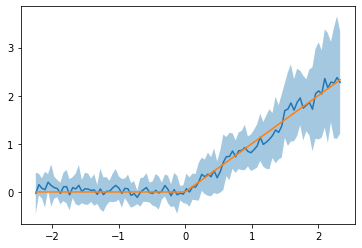

In [55]:
import matplotlib.pyplot as plt
for t in range(n_treatments):
    plt.plot(X_test[:, 0], point[:, t])
    if est.inference:
        plt.fill_between(X_test[:, 0], lb[:, t], ub[:, t], alpha=.4)
    plt.plot(X_test[:, 0], true_te(X_test)[:, t])
plt.show()

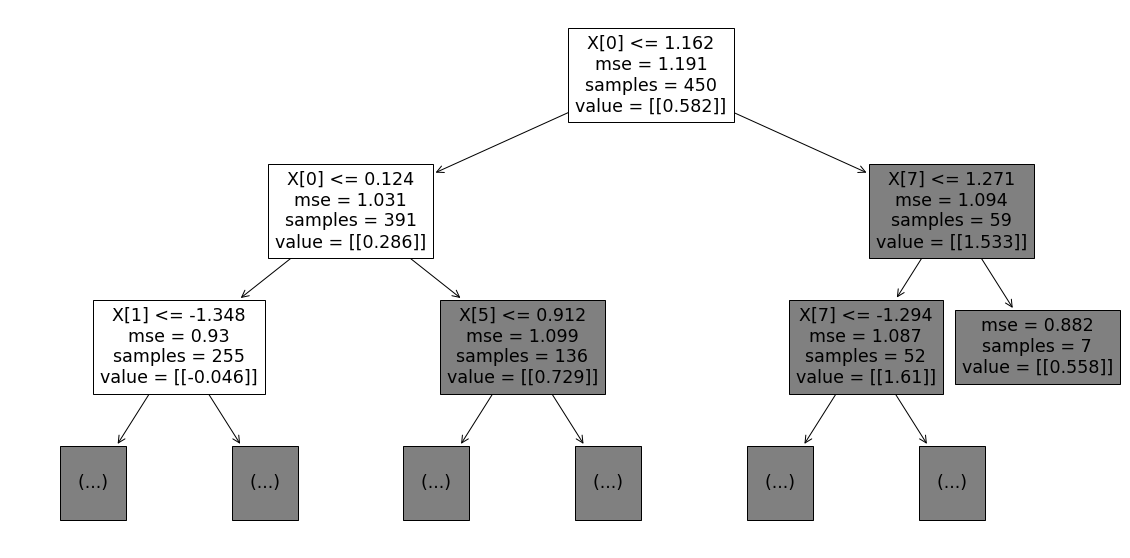

In [56]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 10))
plot_tree(est[1], impurity=True, max_depth=2)
plt.show()

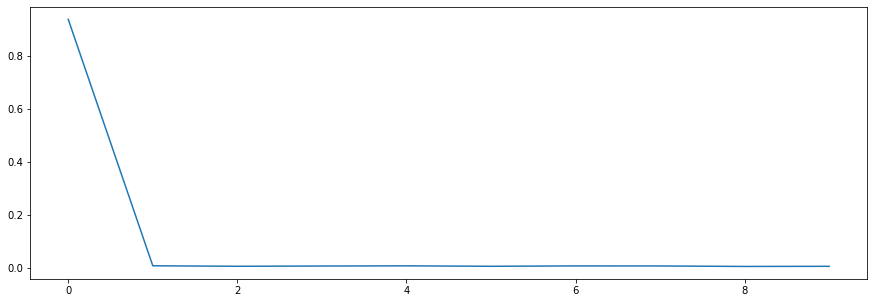

In [57]:
plt.figure(figsize=(15,5))
plt.plot(est.feature_importances(max_depth=4, depth_decay_exponent=2.0))
plt.show()

In [58]:
est.decision_path(X_test[:1])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 4000 out of 4000 | elapsed:    1.0s finished


(<1x481132 sparse matrix of type '<class 'numpy.int64'>'
 	with 38878 stored elements in Compressed Sparse Row format>,
 array([     0,    111,    234, ..., 480890, 481007, 481132], dtype=int32))

In [59]:
est.apply(X_test[:1])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 4000 out of 4000 | elapsed:    0.3s finished


array([[69, 18, 18, ...,  7, 27, 20]], dtype=int64)

### Running time comparison with a simple regression forest predicting the treatments

In [12]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=4000, min_samples_leaf=40, max_samples=.45, n_jobs=-1, max_depth=None, verbose=0)

In [ ]:
%time rf.fit(X, np.hstack([T, T[:, [0]]]))
%time pred = rf.predict(X)

### Comparison with ForestDML

In [14]:
from econml.dml import ForestDML
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LassoCV, LogisticRegressionCV
from sklearn.ensemble import RandomForestRegressor
est = ForestDML(model_y=RandomForestRegressor(min_samples_leaf=100),
                model_t=RandomForestRegressor(min_samples_leaf=100),
                n_estimators=4000, min_samples_leaf=20, subsample_fr=.9,
                max_depth=100, verbose=0, n_jobs=-1)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
%time est.fit(y, T, X=X)

In [ ]:
%time point = est.effect(X_test)

In [ ]:
%time lb, ub = est.effect_interval(X_test, alpha=0.01)

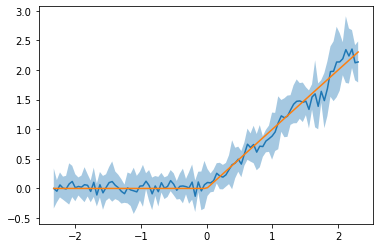

In [18]:
import matplotlib.pyplot as plt
for t in range(n_treatments):
    plt.plot(X_test[:, 0], point[:, t])
    plt.fill_between(X_test[:, 0], lb[:, t], ub[:, t], alpha=.4)
    plt.plot(X_test[:, 0], true_te(X_test)[:, t])
plt.show()

# IV Causal Forest

In [41]:
import numpy as np
import scipy.special
np.random.seed(1227)
n_samples = 5000
n_features = 10
n_treatments = 2
n_outputs = 1
# true_te = lambda X: np.hstack([X[:, [0]]**2 + 1, np.ones((X.shape[0], n_treatments - 1))])
true_te = lambda X: np.hstack([X[:, [0]]>0, np.ones((X.shape[0], n_treatments - 1))])
# true_te = lambda X: np.hstack([(X[:, [0]]>0) * X[:, [0]],
#                                np.ones((X.shape[0], n_treatments - 1))*np.arange(1, n_treatments).reshape(1, -1)])
Z = np.random.normal(0, 1, size=(n_samples, n_treatments))
X = np.random.normal(0, 1, size=(n_samples, n_features))
U = np.random.normal(0, .2, size=(n_samples, 1))
T = np.random.normal(0, 1, size=(n_samples, n_treatments))
for t in range(n_treatments):
    T[:, t] += U[:, 0] + Z[:, t]
y = np.sum(true_te(X) * T, axis=1, keepdims=True) + 10*U[:, [0]]
X_test = X[:1000].copy()
X_test[:, 0] = np.linspace(np.percentile(X[:, 0], 1), np.percentile(X[:, 0], 99), 1000)

In [42]:
from econml.grf import CausalIVForest
est = CausalIVForest(criterion='mse', n_estimators=4000, min_samples_leaf=40,
                     min_var_leaf=0.01, min_impurity_decrease = 0.001, max_samples=.45, max_depth=None,
                     warm_start=False, inference=True, subforest_size=4,
                     honest=True, verbose=0, n_jobs=-1, random_state=123)

In [43]:
%time est.fit(X, T, y, Z=Z)

Wall time: 23.4 s


CausalIVForest(min_impurity_decrease=0.001, min_samples_leaf=40,
               min_var_leaf=0.01, n_estimators=4000, random_state=123)

In [44]:
%time point, lb, ub = est.predict(X_test, interval=True, alpha=0.01)

Wall time: 3.19 s


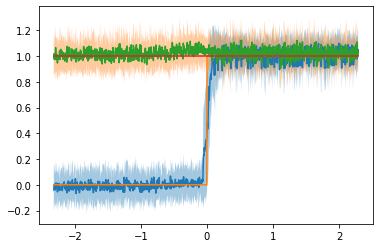

In [45]:
import matplotlib.pyplot as plt
for t in range(n_treatments):
    plt.plot(X_test[:, 0], point[:, t])
    if est.inference:
        plt.fill_between(X_test[:, 0], lb[:, t], ub[:, t], alpha=.4)
    plt.plot(X_test[:, 0], true_te(X_test)[:, t])
plt.show()

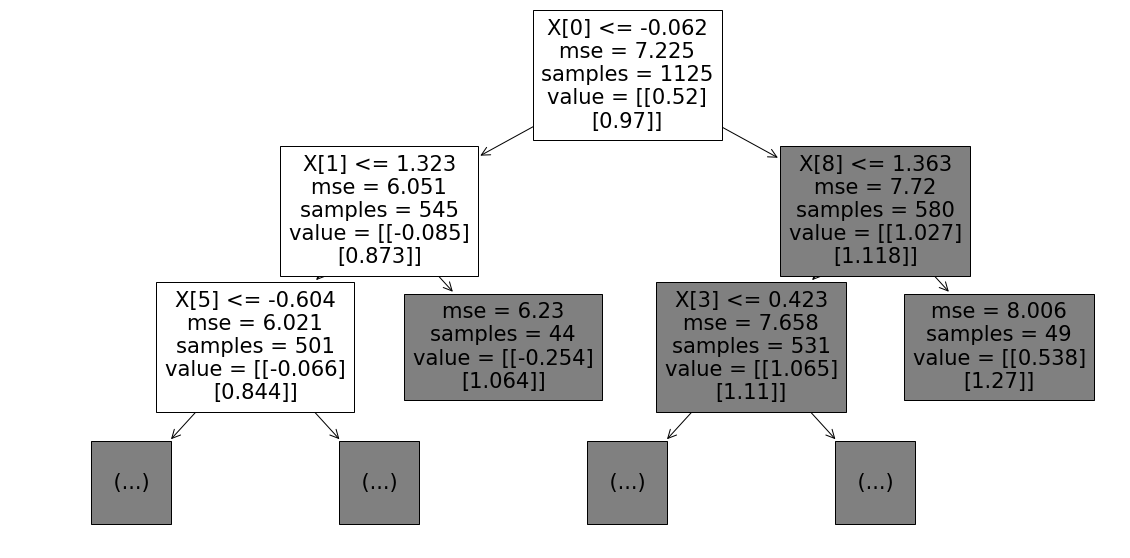

In [46]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 10))
plot_tree(est[0], impurity=True, max_depth=2)
plt.show()

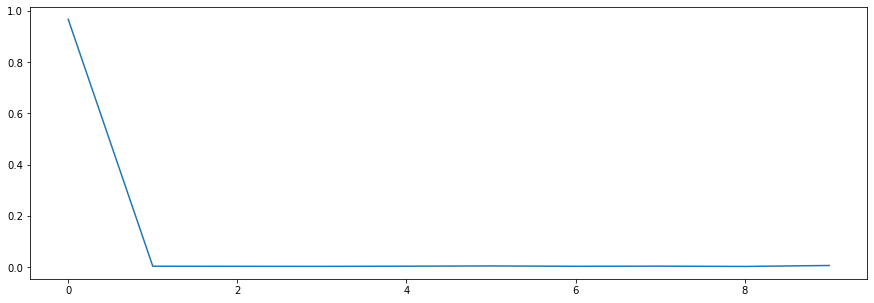

In [47]:
plt.figure(figsize=(15,5))
plt.plot(est.feature_importances(max_depth=4, depth_decay_exponent=2.0))
plt.show()

In [48]:
est[0].decision_path(X_test[:1])

<1x41 sparse matrix of type '<class 'numpy.int64'>'
	with 8 stored elements in Compressed Sparse Row format>

In [49]:
est[0].apply(X_test[:1])

array([12], dtype=int64)

# Regression Forest

In [22]:
import numpy as np
import scipy.special
np.random.seed(123)
n_samples = 2000
n_features = 10
n_outputs = 2
true_te = lambda X: np.hstack([X[:, [0]]**2 + 1, np.ones((X.shape[0], n_outputs - 1))])
# true_te = lambda X: np.hstack([X[:, [0]]>0, np.ones((X.shape[0], n_outputs - 1))])
# true_te = lambda X: np.hstack([(X[:, [0]]>0) * X[:, [0]],
#                                np.ones((X.shape[0], n_outputs - 1))*np.arange(1, n_outputs).reshape(1, -1)])
X = np.random.normal(0, 1, size=(n_samples, n_features))
y = true_te(X) + 0.0 * X[:, [0]] + np.random.normal(0, .1, size=(n_samples, 1))
X_test = X[:min(100, n_samples)].copy()
X_test[:, 0] = np.linspace(np.percentile(X[:, 0], 1), np.percentile(X[:, 0], 99), min(100, n_samples))

In [23]:
from econml.grf import RegressionForest
est = RegressionForest(n_estimators=4000, min_samples_leaf=5, max_depth=None,
                       min_impurity_decrease = 0.0, max_samples=0.45, min_balancedness_tol=.45,
                       warm_start=False, inference=True, subforest_size=4,
                       honest=True, verbose=1, n_jobs=-1, random_state=1235)

In [24]:
%time est.fit(X, y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    5.1s


Wall time: 8.64 s


[Parallel(n_jobs=-1)]: Done 4000 out of 4000 | elapsed:    6.3s finished


RegressionForest(n_estimators=4000, random_state=1235, verbose=1)

In [28]:
%time point, lb, ub = est.predict(X_test, interval=True, alpha=0.01)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 4000 out of 4000 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.4s


Wall time: 1.7 s


[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.9s finished


In [29]:
%time point = est.predict(X_test, interval=False, alpha=0.01)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed:    0.3s


Wall time: 672 ms


[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 4000 out of 4000 | elapsed:    0.5s finished


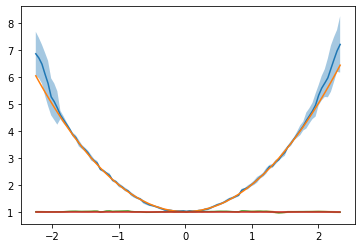

In [30]:
import matplotlib.pyplot as plt
for t in range(n_outputs):
    plt.plot(X_test[:, 0], point[:, t])
    if est.inference:
        plt.fill_between(X_test[:, 0], lb[:, t], ub[:, t], alpha=.4)
    plt.plot(X_test[:, 0], true_te(X_test)[:, t])
plt.show()

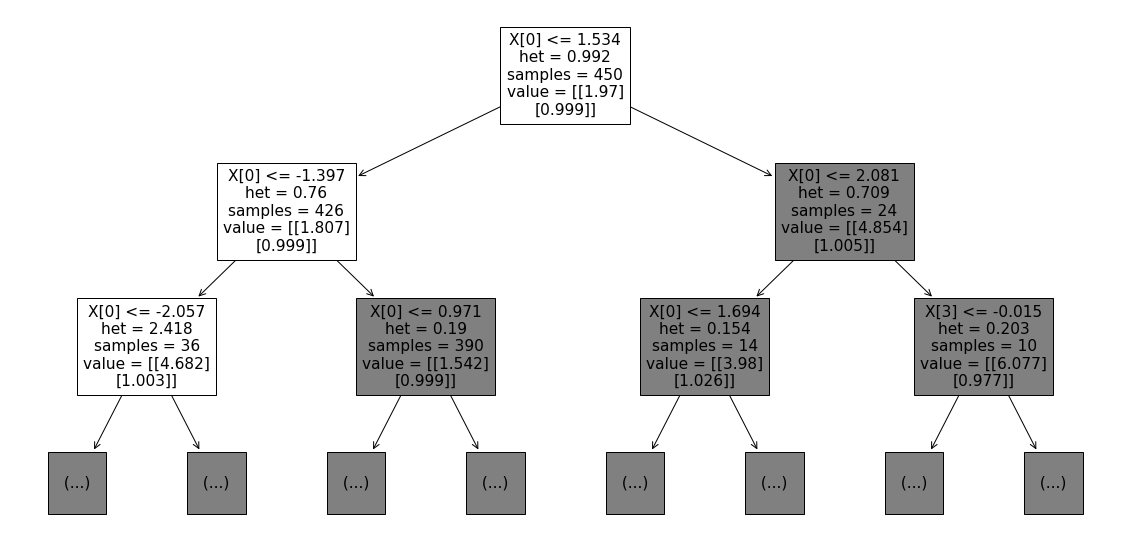

In [31]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 10))
plot_tree(est[0], impurity=True, max_depth=2)
plt.show()

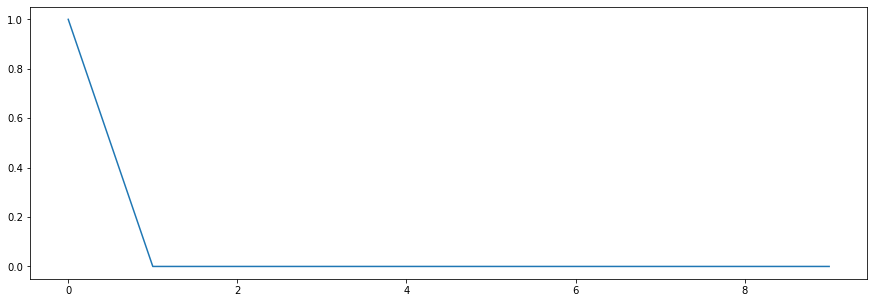

In [32]:
plt.figure(figsize=(15,5))
plt.plot(est.feature_importances(max_depth=4, depth_decay_exponent=2.0))
plt.show()

# Combining with DML

In [1]:
import numpy as np
import scipy.special
np.random.seed(123)
n_samples = 5000
n_features = 10
n_treatments = 2
n_outputs = 3
true_te = lambda X: np.hstack([X[:, [0]]**2 + 1, np.ones((X.shape[0], n_treatments - 1))])
# true_te = lambda X: np.hstack([X[:, [0]]>0, np.ones((X.shape[0], n_treatments - 1))])
# true_te = lambda X: np.hstack([(X[:, [0]]>0) * X[:, [0]],
#                                np.ones((X.shape[0], n_treatments - 1))*np.arange(1, n_treatments).reshape(1, -1)])
X = np.random.normal(0, 1, size=(n_samples, n_features))
W = np.random.normal(0, 1, size=(n_samples, n_features))
T = np.random.normal(0, 1, size=(n_samples, n_treatments))
for t in range(n_treatments):
    T[:, t] = np.random.binomial(1, scipy.special.expit(X[:, 0]))
# T[:, 1] = .9 * T[:, 0] + .1 * T[:, 1]
y = np.sum(true_te(X) * T, axis=1, keepdims=True) + 5.0 * X[:, [0]] + np.random.normal(0, .1, size=(n_samples, 1))
y = np.tile(y, (1, n_outputs))
for j in range(n_outputs):
    y[:, j] = (j + 1) * y[:, j]
X_test = X[:min(100, n_samples)].copy()
X_test[:, 0] = np.linspace(np.percentile(X[:, 0], 1), np.percentile(X[:, 0], 99), min(100, n_samples))

In [2]:
from econml.dml import CausalForestDML
est = CausalForestDML(criterion='mse', n_estimators=100, min_var_leaf=None,
                      verbose=1, discrete_treatment=False,
                      n_jobs=-1, random_state=123).fit(y, T, X=X, W=W)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Paral

In [3]:
est.marginal_effect(np.ones((X_test.shape[0], n_treatments)), X_test).shape

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


(100, 3, 2)

In [4]:
res = est.const_marginal_effect_inference(X_test)
point = res.point_estimate
lb, ub = res.conf_int(alpha=.01)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurr

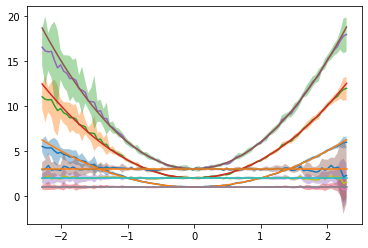

In [5]:
import matplotlib.pyplot as plt
for t in range(n_treatments):
    for j in range(n_outputs):
        plt.plot(X_test[:, 0], point[:, j, t])
        plt.fill_between(X_test[:,0], lb[:, j, t], ub[:, j, t], alpha=.4)
        plt.plot(X_test[:, 0], (j + 1) * true_te(X_test)[:, t])
plt.show()

In [6]:
res.summary_frame()

point_estimate        stderr          zstat        pvalue         \
                  T0     T1     T0     T1      T0     T1     T0     T1   
0  Y0          5.514  0.979  0.257  0.107  21.426  9.162    0.0  0.000   
   Y1         11.029  1.957  0.515  0.214  21.426  9.162    0.0  0.000   
   Y2         16.543  2.936  0.772  0.320  21.426  9.162    0.0  0.000   
1  Y0          5.376  0.999  0.500  0.132  10.759  7.583    0.0  0.000   
   Y1         10.751  1.999  0.999  0.264  10.759  7.583    0.0  0.000   
...              ...    ...    ...    ...     ...    ...    ...    ...   
98 Y1         11.857  1.430  0.499  1.069  23.759  1.337    0.0  0.181   
   Y2         17.785  2.145  0.749  1.604  23.759  1.337    0.0  0.181   
99 Y0          5.984  0.762  0.247  0.405  24.244  1.882    0.0  0.060   
   Y1         11.968  1.523  0.494  0.810  24.244  1.882    0.0  0.060   
   Y2         17.952  2.285  0.740  1.214  24.244  1.882    0.0  0.060   

      ci_lower        ci_upper         
            T0     T1       T0     T1  
0  Y0    5.091  0.803    5.938  1.154  
   Y1   10.182  1.606   11.876  2.309  
   Y2   15.273  2.409   17.813  3.463  
1  Y0    4.554  0.783    6.198  1.216  
   Y1    9.108  1.565   12.395  2.432  
...        ...    ...      ...    ...  
98 Y1   11.036 -0.329   12.678  3.189  
   Y2   16.554 -0.494   19.016  4.783  
99 Y0    5.578  0.096    6.390  1.428  
   Y1   11.156  0.192   12.780  2.855  
   Y2   16.734  0.288   19.170  4.283  

[300 rows x 12 columns]

In [7]:
res = est.effect_inference(X_test)
point = res.point_estimate
lb, ub = res.conf_int(alpha=0.01)

C:\ProgramData\Anaconda3\lib\site-packages\econml\cate_estimator.py:456: UserWarning: A scalar was specified but there are multiple treatments; the same value will be used for each treatment.  Consider specifyingall treatments, or using the const_marginal_effect method.
  warn("A scalar was specified but there are multiple treatments; "
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel

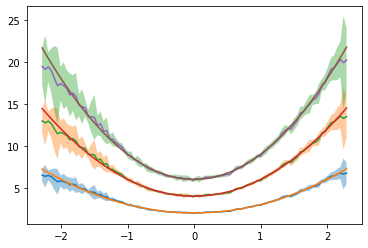

In [8]:
import matplotlib.pyplot as plt
for j in range(n_outputs):
    plt.plot(X_test[:, 0], point[:, j])
    plt.fill_between(X_test[:,0], lb[:, j], ub[:, j], alpha=.4)
    plt.plot(X_test[:, 0], (j + 1) * np.sum(true_te(X_test), axis=1))
plt.show()

In [9]:
res.summary_frame()

point_estimate  stderr   zstat  pvalue  ci_lower  ci_upper
0  Y0           6.493   0.284  22.860     0.0     6.026     6.960
   Y1          12.986   0.568  22.860     0.0    12.052    13.921
   Y2          19.479   0.852  22.860     0.0    18.078    20.881
1  Y0           6.375   0.525  12.147     0.0     5.512     7.238
   Y1          12.750   1.050  12.147     0.0    11.024    14.477
...               ...     ...     ...     ...       ...       ...
98 Y1          13.287   1.435   9.260     0.0    10.926    15.647
   Y2          19.930   2.152   9.260     0.0    16.390    23.470
99 Y0           6.746   0.501  13.468     0.0     5.922     7.569
   Y1          13.491   1.002  13.468     0.0    11.844    15.139
   Y2          20.237   1.503  13.468     0.0    17.765    22.708

[300 rows x 6 columns]

In [10]:
est.feature_importances_

array([[0.92928626, 0.00330014, 0.00795522, 0.00126622, 0.00620156,
        0.01959021, 0.00741833, 0.00297892, 0.01180256, 0.01020059],
       [0.92928626, 0.00330014, 0.00795522, 0.00126622, 0.00620156,
        0.01959021, 0.00741833, 0.00297892, 0.01180256, 0.01020059],
       [0.92928626, 0.00330014, 0.00795522, 0.00126622, 0.00620156,
        0.01959021, 0.00741833, 0.00297892, 0.01180256, 0.01020059]])

#### Comparison with OrthoForest

In [ ]:
from econml.ortho_forest import DMLOrthoForest
est = DMLOrthoForest(lambda_reg=1000, discrete_treatment=True).fit(y, T, X, W)

In [ ]:
point = est.const_marginal_effect(X_test)

In [ ]:
lb, ub = est.const_marginal_effect_interval(X_test)

In [ ]:
import matplotlib.pyplot as plt
for t in range(n_treatments):
    plt.plot(X_test[:, 0], point[:, 0])
    plt.fill_between(X_test[:,0], lb[:, 0], ub[:, 0], alpha=.4)
    plt.plot(X_test[:, 0], true_te(X_test)[:, t])
plt.show()